In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import argparse
import os
from tqdm import tqdm
import time
import math

from net.network import AttentionNet, Encoder, Decoder, SelfAttention
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser()
# Basic options
parser.add_argument('--dataset_dir', type=str, default='./datasets/style_set/val2014',
                    help='Directory path to a batch of content images')
# parser.add_argument('--dataset_dir', type=str, default='./datasets/style_set/val2014',
#                     help='Directory path to a batch of style images')
# parser.add_argument('--dataset_dir', type=str, default='./datasets/content_style_mix_set/val2014',
#                     help='Directory path to a batch of style images')


# training options
parser.add_argument('--save_dir', default='./models/style',
                    help='Directory to save the model')
parser.add_argument('--log_dir', default='./logs',
                    help='Directory to save the log')
parser.add_argument('--lr', type=float, default=1e-4)
parser.add_argument('--lr_decay', type=float, default=5e-5)
parser.add_argument('--max_iter', type=int, default=80000)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--n_threads', type=int, default=2)
parser.add_argument('--save_model_interval', type=int, default=100)
parser.add_argument('--start_iter', type=float, default=65400)
parser.add_argument('--seperate', type=bool, default=False)
args = parser.parse_args('')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

In [4]:
# transforms.Normalize((0, 0, 0), (1/255.0, 1/255.0, 1/255.0))
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
}

class FlatFolderDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = os.listdir(self.root)
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

train_set = FlatFolderDataset(args.dataset_dir, data_transforms['train'])
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=args.batch_size,
    shuffle=True, num_workers=args.n_threads)
train_iter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


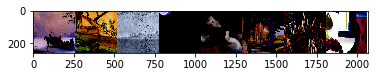

In [5]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images = dataiter.next()
print(images[0].size())
# show images
imshow(torchvision.utils.make_grid(images))


In [6]:
def get_optimizer(model, seperate):
    for param in model.encode.parameters():
        param.requires_grad = False
    if seperate == True:
        optimizer = torch.optim.Adam([
            {'params': model.self_attn_content.parameters()},
            {'params': model.self_attn_style.parameters()},
            {'params': model.content_decode.parameters()},
            {'params': model.style_decode.parameters()},
        ], lr=args.lr)
    else:
        optimizer = torch.optim.Adam([
            {'params': model.decode.parameters()},
            {'params': model.self_attn.parameters()},
        ], lr=args.lr)
    return optimizer

if(args.start_iter > 0):
    decoder = Decoder()
    decoder.load_state_dict(torch.load(args.save_dir + '/decoder_iter_' + str(args.start_iter) + '.pth'))
    attn = SelfAttention()
    attn.load_state_dict(torch.load(args.save_dir + '/attention_kernel_iter_' + str(args.start_iter) + '.pth'))
    
    state_dict = decoder.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    state_dict = attn.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    
    model = AttentionNet(seperate=args.seperate, attn=attn, decoder = decoder)
    optimizer = get_optimizer(model, args.seperate)
    optimizer.load_state_dict(torch.load(args.save_dir + '/optimizer_iter_' + str(args.start_iter) + '.pth'))
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()
else:
    model = AttentionNet(seperate=args.seperate)
    optimizer = get_optimizer(model, args.seperate)

model.to(device)   
loss_seq = {'total': [], 'construct': [], 'percept': [], 'tv': [], 'attn': []}

In [7]:
def lastest_arverage_value(values, length=100):
    if len(values) < length:
        length = len(values)
    return sum(values[-length:])/length

def adjust_learning_rate(optimizer, iteration_count):
    """Imitating the original implementation"""
    lr = args.lr / (1.0 + args.lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
reload_period = len(train_loader.dataset) / args.batch_size
reload_period = math.floor(reload_period)
for i in tqdm(range(args.start_iter, args.max_iter)):
    adjust_learning_rate(optimizer, iteration_count=i)
    
    if (i - args.start_iter)%reload_period == 0:
        train_loader = torch.utils.data.DataLoader(
            train_set, batch_size=args.batch_size,
            shuffle=True, num_workers=args.n_threads)
        train_iter = iter(train_loader)
        
    if args.seperate == False:
        content_images = next(train_iter).to(device)
        losses, _, _ = model(content_images)
        
    total_loss = losses['total']
    
    for name, vals in loss_seq.items():
        loss_seq[name].append(losses[name].item())
        
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (i + 1) % args.save_model_interval == 0 or (i + 1) == args.max_iter:
        print("%s: Iteration: [%d/%d]\tRecon Loss: %2.4f\tPercept Loss: %2.4f\tTV Loss: %2.4f\tAttn Loss: %2.4f\tTotal: %2.4f"%(time.ctime(),i+1, 
                args.max_iter, lastest_arverage_value(loss_seq['construct']), lastest_arverage_value(loss_seq['percept']), 
                lastest_arverage_value(loss_seq['tv']), lastest_arverage_value(loss_seq['attn']), lastest_arverage_value(loss_seq['total'])))
        if args.seperate == False:
            state_dict = model.decode.state_dict()
            for key in state_dict.keys():
                state_dict[key] = state_dict[key].to(torch.device('cpu'))
            torch.save(state_dict,
                       '{:s}/decoder_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
            state_dict = model.self_attn.state_dict()
            for key in state_dict.keys():
                state_dict[key] = state_dict[key].to(torch.device('cpu'))
            torch.save(state_dict,
                       '{:s}/attention_kernel_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
            state_dict = optimizer.state_dict()
            torch.save(state_dict,
                       '{:s}/optimizer_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
        else:
            pass
    
    

  1%|          | 99/14600 [00:35<1:25:39,  2.82it/s]

Mon Jun 29 11:01:53 2020: Iteration: [65500/80000]	Recon Loss: 455.8877	Percept Loss: 40344.2993	TV Loss: 11.0062	Attn Loss: 5.8920	Total: 45048.5911


  1%|▏         | 199/14600 [01:11<1:27:01,  2.76it/s]

Mon Jun 29 11:02:29 2020: Iteration: [65600/80000]	Recon Loss: 446.2714	Percept Loss: 40876.3724	TV Loss: 10.8067	Attn Loss: 6.1875	Total: 45484.2787


  2%|▏         | 299/14600 [01:47<1:26:03,  2.77it/s]

Mon Jun 29 11:03:05 2020: Iteration: [65700/80000]	Recon Loss: 446.0061	Percept Loss: 40565.3636	TV Loss: 10.8323	Attn Loss: 5.1836	Total: 45164.8486


  3%|▎         | 399/14600 [02:23<1:26:39,  2.73it/s]

Mon Jun 29 11:03:41 2020: Iteration: [65800/80000]	Recon Loss: 454.3896	Percept Loss: 40238.9775	TV Loss: 10.9566	Attn Loss: 5.6600	Total: 44926.3993


  3%|▎         | 499/14600 [02:59<1:25:15,  2.76it/s]

Mon Jun 29 11:04:18 2020: Iteration: [65900/80000]	Recon Loss: 431.2345	Percept Loss: 39287.7395	TV Loss: 10.7701	Attn Loss: 6.0679	Total: 43744.1931


  4%|▍         | 599/14600 [03:36<1:24:30,  2.76it/s]

Mon Jun 29 11:04:54 2020: Iteration: [66000/80000]	Recon Loss: 441.3163	Percept Loss: 40163.0176	TV Loss: 10.8266	Attn Loss: 5.8185	Total: 44719.3575


  5%|▍         | 699/14600 [04:12<1:23:45,  2.77it/s]

Mon Jun 29 11:05:30 2020: Iteration: [66100/80000]	Recon Loss: 423.0855	Percept Loss: 39558.7302	TV Loss: 10.6366	Attn Loss: 6.0143	Total: 43932.0368


  5%|▌         | 751/14600 [04:31<1:23:40,  2.76it/s]/home/dehezhang2/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94435468 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
  5%|▌         | 799/14600 [04:49<1:23:39,  2.75it/s]

Mon Jun 29 11:06:07 2020: Iteration: [66200/80000]	Recon Loss: 446.3707	Percept Loss: 41153.9767	TV Loss: 10.8896	Attn Loss: 5.6189	Total: 45760.2930


  6%|▌         | 899/14600 [05:26<1:23:13,  2.74it/s]

Mon Jun 29 11:06:44 2020: Iteration: [66300/80000]	Recon Loss: 440.0774	Percept Loss: 40057.1150	TV Loss: 10.8516	Attn Loss: 5.9033	Total: 44601.8253


  7%|▋         | 999/14600 [06:02<1:21:53,  2.77it/s]

Mon Jun 29 11:07:20 2020: Iteration: [66400/80000]	Recon Loss: 459.1420	Percept Loss: 40260.5740	TV Loss: 10.8887	Attn Loss: 5.8332	Total: 44995.8800


  7%|▋         | 1016/14600 [06:08<1:23:58,  2.70it/s]

In [ ]:
train_iter = iter(train_loader)
content_images = next(train_iter).to(device)
losses, recon_images, attn_map = model(content_images)
print(recon_images.size())
print(attn_map.size())

In [ ]:
imshow(torchvision.utils.make_grid(content_images.cpu()[2]))

In [ ]:
def imshow_recon(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow_recon(torchvision.utils.make_grid(recon_images.cpu()[2]))

In [ ]:
channel_num = attn_map.size()[1]
mean_sal = torch.mean(attn_map, 1, False)
mean_sal_np = mean_sal.cpu().detach().numpy()
mean_sal_np = mean_sal_np - np.min(mean_sal_np)
mean_sal_np = mean_sal_np * 1.0 / np.max(mean_sal_np)
print(mean_sal.size())
plt.imshow(mean_sal_np[2], cmap=cm.get_cmap('rainbow', 1000))
plt.colorbar()
plt.axis('off')